In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset


import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from nltk.tokenize import word_tokenize

import string

import matplotlib.pyplot as plt

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
device

device(type='cpu')

Importing the different datasets

In [4]:
import os

train_df = pd.read_csv(os.getcwd() + "/data/train.csv")
test_df = pd.read_csv(os.getcwd() + "/data/test.csv")

In [5]:
validation = pd.read_csv("data/validation.csv")
idx = pd.Series.to_list(validation["tweet_id"])


df_unpacked = pd.read_pickle("preprocess_vader.pkl")
df_no_hashtags = pd.read_pickle("preprocess_vader_no_hashtags.pkl")

mask1 = df_no_hashtags['tweet_id'].isin(idx)
mask2 = df_unpacked['tweet_id'].isin(idx)

df_validation_no_hashtags = df_no_hashtags.loc[mask1]
df_validation_unpacked = df_unpacked.loc[mask2]

In [6]:
df_unpacked

,tweet_id,author_id,tweet,lang,tweet_time,like_count,follower_count,following_count,tweet_count,retweet_count,quote_count,reply_count,call_berlin_time,annotate_sent,annotate_person,lowercase,tokenized
0,1388362599310532608,1558653817,@hum_dekhege @HamidMirPAK Start with reforms i...,en,2021-05-01 05:20:12+00:00,1,906,4352,14668,0,0,1,2022-05-07 11:20:23,NaN,NaN,@hum_dekhege @hamidmirpak start with reforms i...,<user> <user> start with reforms instead of ta...
1,1388387848466968579,1367303714994860032,@0xMoonbags Yeah if you looking for inflation ...,en,2021-05-01 07:00:32+00:00,0,387,807,3041,0,0,0,2022-05-07 11:20:23,NaN,NaN,@0xmoonbags yeah if you looking for inflation ...,<user> yeah if you looking for inflation prote...
2,1388452435795005442,1290659739324604416,They won't invest in something they don't beli...,en,2021-05-01 11:17:11+00:00,10,377,1194,42807,0,0,0,2022-05-07 11:20:23,0.0,P,they won't invest in something they don't beli...,they won't invest in something they don't beli...
3,1388500362479357958,996689497818652673,@AngelaMerkeICDU oops..its 6 nation..INDIA EXC...,en,2021-05-01 14:27:38+00:00,1,0,1,39682,0,0,1,2022-05-07 11:20:23,NaN,NaN,@angelamerkeicdu oops..its 6 nation..india exc...,<user> oops..its <number> nation..india exclud...
4,1388551940137750528,1387378888213413888,@SchwarzwaldSoze @Kurnugia1 @heyitsMaddie_x @C...,en,2021-05-01 17:52:35+00:00,0,109,93,2571,0,0,0,2022-05-07 11:20:23,NaN,NaN,@schwarzwaldsoze @kurnugia1 @heyitsmaddie_x @c...,<user> <user> <user> <user> <user> <user> <use...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8756,1520114612615749632,947138522837913600,@marcfriedrich7 Die snb kann so viel interveni...,de,2022-04-29 18:55:40+00:00,6,29,96,362,0,0,2,2022-05-07 11:20:23,0.0,P,@marcfriedrich7 die snb kann so viel interveni...,<user> die snb kann so viel intervenieren wie ...
8757,1520124379237126144,535913183,"Other European markets higher on Friday, 04/29...",en,2022-04-29 19:34:29+00:00,0,10012,575,59516,0,0,0,2022-05-07 11:20:23,NaN,NaN,"other european markets higher on friday, 04/29...","other european markets higher on friday, <date..."
8758,1520128302081523714,1386109443830603780,"@townhallcom @JimFlesher3 So, how come inflati...",en,2022-04-29 19:50:04+00:00,0,323,620,868,0,0,0,2022-05-07 11:20:23,NaN,NaN,"@townhallcom @jimflesher3 so, how come inflati...","<user> <user> so, how come inflation un switze..."
8759,1520157526549016576,719914763820654592,#Swiss National Bank (SNB) Opposes Using Bitco...,en,2022-04-29 21:46:12+00:00,0,573,537,58860,0,0,0,2022-05-07 11:20:23,NaN,NaN,#swiss national bank (snb) opposes using bitco...,swiss national bank (snb) opposes using bitcoi...


In [7]:
df_no_hashtags

,tweet_id,author_id,tweet,lang,tweet_time,like_count,follower_count,following_count,tweet_count,retweet_count,quote_count,reply_count,call_berlin_time,annotate_sent,annotate_person,lowercase,tokenized
0,1388362599310532608,1558653817,@hum_dekhege @HamidMirPAK Start with reforms i...,en,2021-05-01 05:20:12+00:00,1,906,4352,14668,0,0,1,2022-05-07 11:20:23,NaN,NaN,@hum_dekhege @hamidmirpak start with reforms i...,<user> <user> start with reforms instead of ta...
1,1388387848466968579,1367303714994860032,@0xMoonbags Yeah if you looking for inflation ...,en,2021-05-01 07:00:32+00:00,0,387,807,3041,0,0,0,2022-05-07 11:20:23,NaN,NaN,@0xmoonbags yeah if you looking for inflation ...,<user> yeah if you looking for inflation prote...
2,1388452435795005442,1290659739324604416,They won't invest in something they don't beli...,en,2021-05-01 11:17:11+00:00,10,377,1194,42807,0,0,0,2022-05-07 11:20:23,0.0,P,they won't invest in something they don't beli...,they won't invest in something they don't beli...
3,1388500362479357958,996689497818652673,@AngelaMerkeICDU oops..its 6 nation..INDIA EXC...,en,2021-05-01 14:27:38+00:00,1,0,1,39682,0,0,1,2022-05-07 11:20:23,NaN,NaN,@angelamerkeicdu oops..its 6 nation..india exc...,<user> oops..its <number> nation..india exclud...
4,1388551940137750528,1387378888213413888,@SchwarzwaldSoze @Kurnugia1 @heyitsMaddie_x @C...,en,2021-05-01 17:52:35+00:00,0,109,93,2571,0,0,0,2022-05-07 11:20:23,NaN,NaN,@schwarzwaldsoze @kurnugia1 @heyitsmaddie_x @c...,<user> <user> <user> <user> <user> <user> <use...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,1520114612615749632,947138522837913600,@marcfriedrich7 Die snb kann so viel interveni...,de,2022-04-29 18:55:40+00:00,6,29,96,362,0,0,2,2022-05-07 11:20:23,0.0,P,@marcfriedrich7 die snb kann so viel interveni...,<user> die snb kann so viel intervenieren wie ...
8756,1520124379237126144,535913183,"Other European markets higher on Friday, 04/29...",en,2022-04-29 19:34:29+00:00,0,10012,575,59516,0,0,0,2022-05-07 11:20:23,NaN,NaN,"other european markets higher on friday, 04/29...","other european markets higher on friday, <date..."
8757,1520128302081523714,1386109443830603780,"@townhallcom @JimFlesher3 So, how come inflati...",en,2022-04-29 19:50:04+00:00,0,323,620,868,0,0,0,2022-05-07 11:20:23,NaN,NaN,"@townhallcom @jimflesher3 so, how come inflati...","<user> <user> so, how come inflation un switze..."
8758,1520157526549016576,719914763820654592,#Swiss National Bank (SNB) Opposes Using Bitco...,en,2022-04-29 21:46:12+00:00,0,573,537,58860,0,0,0,2022-05-07 11:20:23,NaN,NaN,#swiss national bank (snb) opposes using bitco...,national bank (snb) opposes using bitcoin as a...


In [8]:
train_cols = ["annotate_sent", "tokenized"]
test_cols = ["tokenized"]

In [9]:
train_df = train_df[train_cols]
test_df = test_df[test_cols]
no_hastags_val_df = df_validation_no_hashtags[train_cols]
unpacked_val_df = df_validation_unpacked[train_cols]

In [10]:
test_df

,tokenized
0,"<user> mrs m. schwesig, did the right thing (s..."
1,<user> <user> so you’re saying jt is causing i...
2,"gdp, <number> . ($ billion) germany: <number> ..."
3,<user> wieso soll man eine bundesanleihe kaufe...
4,"<user> <user> $pplt aberdeen, stored with hsbc..."
...,...
307,die schweiz hat ihre langjährige neutralitätsp...
308,<user> <user> <user> <user> <user> <user> yeah...
309,<user> <user> hätte die abopreisgestaltung mit...
310,<user> interest rate (percentage) switzerland ...


In [11]:
no_hastags_val_df

,annotate_sent,tokenized
6,-1.0,. <user> die schweizerische nationalbank verur...
9,-1.0,<user> <user> <user> dass die schweiz eine dem...
48,0.0,<user> theres a huge ticker screen showing gdp...
56,0.0,die teuerung in der schweiz ist wieder positiv...
59,0.0,"<user> <user> <user> <user> , switzerland need..."
...,...,...
8564,1.0,<user> die schweiz sollte uns in jeder hinsich...
8655,-1.0,<user> <user> core inflation in euro zone is r...
8708,-1.0,the effects of inflation bad fx trades and hy ...
8732,0.0,<user> <user> warum ist die inflation in der s...


Replacing the original labels of -1, 0 and 1 to 0, 1 and 2 respectively as the former caused errors during training.

In [12]:
train_df["annotate_sent"] = train_df["annotate_sent"].replace(1.0, 2.0)
train_df["annotate_sent"] = train_df["annotate_sent"].replace(0.0, 1.0)
train_df["annotate_sent"] = train_df["annotate_sent"].replace(-1.0, 0.0)

no_hastags_val_df["annotate_sent"] = no_hastags_val_df["annotate_sent"].replace(1.0, 2.0)
no_hastags_val_df["annotate_sent"] = no_hastags_val_df["annotate_sent"].replace(0.0, 1.0)
no_hastags_val_df["annotate_sent"] = no_hastags_val_df["annotate_sent"].replace(-1.0, 0.0)

unpacked_val_df["annotate_sent"] = unpacked_val_df["annotate_sent"].replace(1.0, 2.0)
unpacked_val_df["annotate_sent"] = unpacked_val_df["annotate_sent"].replace(0.0, 1.0)
unpacked_val_df["annotate_sent"] = unpacked_val_df["annotate_sent"].replace(-1.0, 0.0)

/var/folders/y6/pght29y10p56pqbrywqnnfs40000gn/T/ipykernel_93901/1495201198.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  no_hastags_val_df["annotate_sent"] = no_hastags_val_df["annotate_sent"].replace(1.0, 2.0)
/var/folders/y6/pght29y10p56pqbrywqnnfs40000gn/T/ipykernel_93901/1495201198.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  no_hastags_val_df["annotate_sent"] = no_hastags_val_df["annotate_sent"].replace(0.0, 1.0)
/var/folders/y6/pght29y10p56pqbrywqnnfs40000gn/T/ipykernel_93901/1495201198.

In [13]:
unpacked_val_df

,annotate_sent,tokenized
6,0.0,. <user> die schweizerische nationalbank verur...
9,0.0,<user> <user> <user> dass die schweiz eine dem...
48,1.0,<user> theres a huge ticker screen showing gdp...
56,1.0,die teuerung in der schweiz ist wieder positiv...
59,1.0,"<user> <user> <user> <user> , switzerland need..."
...,...,...
8565,2.0,<user> die schweiz sollte uns in jeder hinsich...
8656,0.0,<user> <user> core inflation in euro zone is r...
8709,0.0,the effects of inflation bad fx trades and hy ...
8733,1.0,<user> <user> warum ist die inflation in der s...


Balancing the amount of each label in the training set such that biases are removed from the training set.

In [14]:
train_df["annotate_sent"].value_counts()

1.0    531
0.0    250
2.0    152
Name: annotate_sent, dtype: int64

In [15]:
remove_neg = 250 - 152
remove_neut = 531 - 152

neg_df = train_df[train_df["annotate_sent"] == 0.0] 
pos_df = train_df[train_df["annotate_sent"] == 2.0] 
neut_df = train_df[train_df["annotate_sent"] == 1.0] 

neg_drop_indices = np.random.choice(neg_df.index, remove_neg, replace=False)
neut_drop_indices = np.random.choice(neut_df.index, remove_neut, replace=False)

neg_undersampled = neg_df.drop(neg_drop_indices)
neut_undersampled = neut_df.drop(neut_drop_indices)

In [16]:
neg_undersampled

,annotate_sent,tokenized
4,0.0,<user> <user> exactly what kind of economy do ...
8,0.0,<user> <user> it’s cos you’re african that’s w...
26,0.0,“there are plenty of culprits. countries like ...
27,0.0,netflix erhöht die preise in der schweiz. glei...
47,0.0,<user> that's correct. bangladesh has a higher...
...,...,...
897,0.0,the operator of russia’s nord stream <number> ...
905,0.0,i just payed starbucks <money> - <number> for ...
917,0.0,<user> absolutely. and i don’t think this is g...
923,0.0,"die ""offizielle schweiz"" also das kapital und ..."


In [17]:
balanced_train_df = pd.concat([pos_df, neg_undersampled, neut_undersampled])

In [18]:
balanced_train_df

,annotate_sent,tokenized
5,2.0,wrap up thoughts: once you clear out the green...
17,2.0,<user> i like the swiss system of percentiles ...
20,2.0,"<user> <user> what trade with switzerland, the..."
24,2.0,<user> <user> it makes me proud to invest in s...
43,2.0,nightgame yesterday with <user> <user> &amp; <...
...,...,...
898,1.0,<user> <user> <user> they’re stablecoins pegge...
908,1.0,<user> <user> i wasn't employed but i do remem...
912,1.0,"gdp, <number> . ($ billion) germany: <number> ..."
915,1.0,<user> <user> israel has a population of aroun...


In [19]:
train_clean_df, test_clean_df = train_test_split(balanced_train_df, test_size=0.15)

In [30]:
train_set = list(train_clean_df.to_records(index=False))
test_set = list(test_clean_df.to_records(index=False))
unpacked_val_set = list(unpacked_val_df.to_records(index=False))
no_hashtags_val_set = list(no_hastags_val_df.to_records(index=False))

In [21]:
train_set[0]

(1., 'on switzerland f- <number> : figure includes weapons, an inflation ceiling calculated out to <number> , cost of aircraft, spares and support. so, no, unitary fly away cost and total/ <number> jets will always be different. same x everyone: slovakia is paying <number> billion euro for <number> second-hand rafale')

Remove the awry punctuation and replace tags with replacement words/phrases

In [29]:
def remove_tags(tweet):
    tweet = word_tokenize(tweet)
    new_tweet = []
    for word in tweet:
        if word in string.punctuation:
            continue
        elif word == 'user': 
            new_tweet.append('paula')
        elif word =='percent':
            new_tweet.append('fraction')
        elif word == 'number': 
            new_tweet.append('192')
        elif word =='money':
            new_tweet.append('money')
        elif word == 'date': 
            new_tweet.append('september')
        elif word =='time':
            new_tweet.append('10:16')
        else:
            new_tweet.append(word)
            
    
    return new_tweet

In [51]:
train_set = [(label, tweet) for label, tweet in train_set]
test_set = [(label, tweet) for label, tweet in test_set]
unpacked_val_set = [(label, tweet) for label, tweet in unpacked_val_set]
no_hashtags_val_set = [(label, tweet) for label, tweet in no_hashtags_val_set]

In [31]:
train_set = [(label, remove_tags(tweet)) for label, tweet in train_set]
test_set = [(label, remove_tags(tweet)) for label, tweet in test_set]
unpacked_val_set = [(label, remove_tags(tweet)) for label, tweet in unpacked_val_set]
no_hashtags_val_set = [(label, remove_tags(tweet)) for label, tweet in no_hashtags_val_set]

In [32]:
unpacked_val_set

[(0.0,
  ['paula',
   'die',
   'schweizerische',
   'nationalbank',
   'verursacht',
   'mit',
   'ihren',
   'investitionen',
   'so',
   'viel',
   'co2-ausstoss',
   'wie',
   'die',
   'ganze',
   'schweiz',
   'im',
   'inland',
   'jetzt',
   'finanzierung',
   'der',
   'klimakrise',
   'stoppen',
   'exit',
   'fossil',
   'fuels',
   'now',
   'paula']),
 (0.0,
  ['paula',
   'paula',
   'paula',
   'dass',
   'die',
   'schweiz',
   'eine',
   'demokratie',
   'ist',
   'in',
   'der',
   'jeder',
   'den',
   'grössten',
   'unsinn',
   'erzählen',
   'kann',
   'und',
   'anständige',
   'leute',
   'beleidigen',
   'kann',
   'beweisen',
   'sie',
   'eindrücklich',
   'ich',
   'hoffe',
   'dass',
   'sie',
   'ausser',
   'braune',
   'luft',
   'auch',
   'aktiv',
   'etwas',
   'zur',
   'volkswirtschaft',
   'beitragen']),
 (1.0,
  ['paula',
   'theres',
   'a',
   'huge',
   'ticker',
   'screen',
   'showing',
   'gdp',
   'stats',
   'at',
   'the',
   'imf',
   '

In [33]:
max_len = 0

for tweet in train_set:
    if len(tweet[-1]) > max_len:
        max_len = len(tweet[-1])
        print(max_len, tweet[-1])

47 ['on', 'switzerland', 'f-', '192', 'figure', 'includes', 'weapons', 'an', 'inflation', 'ceiling', 'calculated', 'out', 'to', '192', 'cost', 'of', 'aircraft', 'spares', 'and', 'support', 'so', 'no', 'unitary', 'fly', 'away', 'cost', 'and', 'total/', '192', 'jets', 'will', 'always', 'be', 'different', 'same', 'x', 'everyone', 'slovakia', 'is', 'paying', '192', 'billion', 'euro', 'for', '192', 'second-hand', 'rafale']
58 ['sometimes', 'ago', 'i', 'created', 'a', 'whatsapp', 'group', 'where', 'i', 'share', 'forex', 'signals', 'daily', 'for', 'free', 'on', 'this', 'fateful', 'day', 'a', 'guy', 'from', 'my', 'signal', 'group', 'came', 'to', 'my', 'dm', 'he', 'told', 'me', 'he', 'had', 'lost', 'a', 'lot', 'of', 'money', 'and', 'needed', 'a', 'good', 'broker', 'to', 'sign', 'up', 'with', 'i', 'asked', 'him', 'to', 'sign', 'up', 'with', 'mine', 'bd', 'swiss']
97 ['paula', 'paula', 'paula', 'paula', 'paula', 'paula', 'paula', 'paula', 'paula', 'paula', 'paula', 'paula', 'paula', 'paula', 'pau

The longet tweets all have a lot of users tagged, we truncate the longer tweets to fit into 32 tokens

In [34]:
seq_length = 32

In [35]:
# Getting indices for all words
index2word = ["<PAD>", "<SOS>", "<EOS>"]

for ds in [train_set, test_set, unpacked_val_set, no_hashtags_val_set]:
    for label, tweet in ds:
        for token in tweet:
            if token not in index2word:
                index2word.append(token)

In [36]:
word2index = {token: idx for idx, token in enumerate(index2word)}

In [37]:
def encode_and_pad(tweet, length):
    sos = [word2index["<SOS>"]]
    eos = [word2index["<EOS>"]]
    pad = [word2index["<PAD>"]]

    if len(tweet) < length - 2: 
        # -2 for SOS and EOS
        n_pads = length - 2 - len(tweet)
        encoded = [word2index[w] for w in tweet]
        return sos + encoded + eos + pad * n_pads 
    else: 
        # truncating if not possible
        encoded = [word2index[w] for w in tweet]
        truncated = encoded[:length - 2]
        return sos + truncated + eos

Encoding the individual tokens for all tweets in all of the datasets via the `encode_and_pad` function.

In [38]:
train_encoded = [(encode_and_pad(tweet, seq_length), label) for label, tweet in train_set]

In [39]:
test_encoded = [(encode_and_pad(tweet, seq_length), label) for label, tweet in test_set]

In [40]:
unpacked_val_encoded = [(encode_and_pad(tweet, seq_length), label) for label, tweet in unpacked_val_set]
no_hashtags_val_encoded = [(encode_and_pad(tweet, seq_length), label) for label, tweet in no_hashtags_val_set]

In [41]:
batch_size = 15

# Creating numpy arrays for training and testing data
train_x = np.array([tweet for tweet, label in train_encoded])
train_y = np.array([label for tweet, label in train_encoded])
test_x = np.array([tweet for tweet, label in test_encoded])
test_y = np.array([label for tweet, label in test_encoded])
unp_val_x = np.array([tweet for tweet, label in unpacked_val_encoded])
unp_val_y = np.array([label for tweet, label in unpacked_val_encoded])
noh_val_x = np.array([tweet for tweet, label in no_hashtags_val_encoded])
noh_val_y = np.array([label for tweet, label in no_hashtags_val_encoded])

# Creating datasets to be then made into data loaders for ease 
# of training/testing/validation
train_ds = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
test_ds = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))
unp_val_ds = TensorDataset(torch.from_numpy(unp_val_x), torch.from_numpy(unp_val_y))
noh_val_ds = TensorDataset(torch.from_numpy(noh_val_x), torch.from_numpy(noh_val_y))

train_dl = DataLoader(train_ds, shuffle=True, batch_size=batch_size, drop_last=True)
test_dl = DataLoader(test_ds, shuffle=True, batch_size=batch_size, drop_last=True)
unp_val_dl = DataLoader(unp_val_ds, shuffle=True, batch_size=batch_size, drop_last=True)
noh_val_dl = DataLoader(noh_val_ds, shuffle=True, batch_size=batch_size, drop_last=True)

### Importing Embedding

In [42]:
emb = pd.read_csv("crosslingual_EN-DE_english_twitter_100d_weighted_modified.txt", sep="\t", quoting = 3, header=None)

In [43]:
emb = emb.drop([0])

In [44]:
emb

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,100
1,aprovechando,-0.050690,-0.028613,-0.123469,-0.086718,0.051095,0.098174,0.031880,0.095694,-0.117551,...,-0.049828,0.046009,0.006953,-0.007559,-0.008366,0.009669,-0.051066,-0.044055,0.049507,0.033026
2,rockettes,0.099354,-0.159400,0.113784,-0.016882,0.002009,-0.051308,-0.036912,-0.046837,-0.029207,...,0.036363,0.021051,-0.048844,-0.018218,0.018138,-0.036648,-0.033500,0.029149,0.029178,0.051709
3,hardeightbbq,0.025547,0.019638,0.013880,-0.177695,0.044175,0.253680,0.091966,0.044890,0.183417,...,-0.021544,-0.037381,-0.043862,0.007097,0.039416,0.081801,0.000810,0.004483,-0.032863,-0.028641
4,_1986,0.006183,-0.383468,0.027578,-0.053422,0.081558,-0.203160,0.084131,0.101772,0.143262,...,0.063323,-0.021400,0.027290,0.040830,0.007620,-0.039382,-0.021321,0.035007,-0.042360,-0.013520
5,#gonp,-0.261025,0.200143,0.022880,0.200431,0.045366,0.094398,0.150660,0.257246,-0.042904,...,0.039636,-0.004435,0.022821,0.008673,-0.005509,0.002873,-0.008768,-0.007574,-0.039070,-0.045124
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
672005,reat,0.446054,-0.078973,0.031663,-0.096024,0.014930,-0.113871,-0.021634,0.125217,0.230305,...,-0.010533,-0.044607,0.018607,0.059594,-0.013711,0.017004,0.061102,-0.003136,0.036665,0.021460
672006,#dichro,-0.297344,0.211454,-0.080504,-0.119955,-0.199325,-0.082151,-0.050762,-0.269966,0.011062,...,0.021604,-0.003365,-0.078799,-0.005785,0.042388,-0.053921,-0.019712,-0.011081,0.021684,0.020114
672007,seedlings,0.234437,0.141972,0.078025,-0.241339,-0.022374,0.267843,-0.164493,0.075494,-0.046026,...,0.015137,-0.048329,0.004073,-0.074794,0.010211,0.020519,0.026486,-0.002136,-0.081113,-0.035534
672008,#delicius,-0.256561,0.014379,-0.389354,-0.236044,0.168980,0.215358,-0.066428,0.084680,0.114737,...,-0.036187,-0.005084,-0.046340,0.010347,-0.051713,0.020160,-0.050806,-0.015753,0.003637,0.003821


In [45]:
dict = {val.values[0]:val.values[1:] for _, val in emb.T.items()}

In [46]:
def create_embedding_matrix(tokenized,embedding_dict,dimension):
  ''' Creates embedding matrix for all the tokens to be used in the datasets '''
  embedding_matrix=np.zeros((len(tokenized)+1,dimension))
 
  for idx, word in enumerate(tokenized):
    if word in embedding_dict:
      embedding_matrix[idx]=embedding_dict[word]
  return embedding_matrix

In [47]:
# Embedding matrix is created for all of the unique words in the dataset via index2word
emb_matrix = create_embedding_matrix(index2word, dict, 100)

### Defining LSTM Model

In [48]:
class LSTM_Sentiment(torch.nn.Module) :
    def __init__(self, vocab_size, embedding_dim, emb_weights, hidden_dim, dropout) :
        super().__init__()

        # The pretrained embedding used is of dimension 100
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.embedding.weight = nn.Parameter(torch.tensor(emb_weights,dtype=torch.float32))

        # The LSTM layer takes in the the embedding size and the tweet size decided.
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)

        # Dropout is used for regularization
        self.dropout = nn.Dropout(dropout)

        # The fully-connected layer for the 3 sentiment labels
        self.fc = nn.Linear(hidden_dim, 3)

    def forward(self, x, h):

        # The input is transformed to embeddings by passing it to the embedding layer
        embs = self.embedding(x)

        # Hidden state and embedding outputs are passed through the LSTM layer
        out, h = self.lstm(embs, h)

        # Dropout is applied and then fed into the fully connected layer
        out = self.dropout(out)
        out = self.fc(out)

        # We get the scores from the final hidden state
        out = out[:, -1]
        return out, h
    
    def init_hidden(self):
        return (torch.zeros(1, batch_size, 32), torch.zeros(1, batch_size, 32))

In [49]:
model = LSTM_Sentiment(len(word2index), 100, emb_matrix, 32, 0.2)
model = model.to(device)

In [50]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 3e-4)

In [51]:
epochs = 100
losses = []
for e in range(epochs):

    h0, c0 =  model.init_hidden()

    h0 = h0.to(device)
    c0 = c0.to(device)

    for batch_idx, batch in enumerate(train_dl):

        input = batch[0].to(device)
        target = batch[1].to(device)

        optimizer.zero_grad()
        with torch.set_grad_enabled(True):
            out, hidden = model(input, (h0, c0))
            loss = criterion(out, target.long())
            loss.backward()
            optimizer.step()
    losses.append(loss.item())

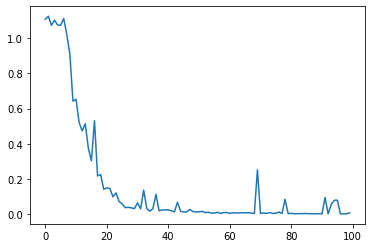

In [52]:
plt.plot(losses)

### Preds

In [53]:
predss = []
batch_acc = []
for batch_idx, batch in enumerate(test_dl):

    input = batch[0].to(device)
    target = batch[1].to(device)

    optimizer.zero_grad()
    with torch.set_grad_enabled(False):
        out, hidden = model(input, (h0, c0))
        _, preds = torch.max(out, 1)
        preds = preds.to("cpu").tolist()
        predss.extend(preds)
        batch_acc.append(accuracy_score(preds, target.tolist()))

sum(batch_acc)/len(batch_acc)

0.5166666666666666

### Validation on No Hashtags

In [54]:
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [55]:
predss = []
targetss = []
batch_acc, f1, prec, recall = [], [], [], []
for batch_idx, batch in enumerate(noh_val_dl):

    input = batch[0].to(device)
    target = batch[1].to(device)

    optimizer.zero_grad()
    with torch.set_grad_enabled(False):
        out, hidden = model(input, (h0, c0))
        _, preds = torch.max(out, 1)
        preds = preds.to("cpu").tolist()
        
        predss.extend(preds)
        targetss.extend(target.tolist())
        batch_acc.append(accuracy_score(preds, target.tolist()))

print(sum(batch_acc)/len(batch_acc))
print(predss)
print(targetss)

0.4666666666666667
[0, 1, 2, 1, 1, 1, 1, 0, 1, 1, 1, 2, 1, 1, 1, 2, 1, 2, 1, 0, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 2, 2, 1, 2, 2, 0, 0, 1, 1, 2, 1, 2, 2, 1, 2, 1, 1, 0, 1, 2, 1, 0, 2, 0, 0, 1, 1, 2, 1, 1, 0, 1, 0, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 2, 2, 2, 1, 0, 2, 2, 1, 0, 2, 1, 1, 2, 2, 2, 0, 2, 0, 1, 1, 0, 0, 1, 2, 0, 1, 1, 1, 1, 2, 2, 2, 2, 2, 1, 1, 2, 1, 1, 2, 1, 2, 2, 1, 1, 1, 1, 2, 2, 1, 1, 2, 2, 1, 0, 0, 1, 2, 0, 1, 0, 1, 2, 2, 1, 1, 2, 2, 2, 1, 2, 1, 1, 2, 2, 2, 2, 2, 1, 2, 1, 1, 1, 1, 0, 2, 2, 2, 2, 1, 1, 1, 2, 2, 2, 1, 2, 2, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 0, 2, 0, 1, 0, 0, 1, 2, 1, 1, 1, 1, 0, 1, 1, 2, 1, 2, 2, 0, 1, 1, 0, 1, 1, 2, 2, 1, 1, 1, 2, 2, 0, 2, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 2, 1, 1, 2, 1, 1, 2, 2, 2, 2, 1, 1, 2, 1, 2, 2, 1, 2, 1, 1, 2, 1, 0, 1, 2, 2, 1, 1, 2, 1, 2, 1, 1, 0, 1, 2, 0, 2, 2, 1, 1, 1, 2, 0, 1, 1, 0, 2, 1, 1, 1, 1, 2, 2, 1, 2, 1, 1, 0, 1, 2, 2, 0, 2, 2, 1, 0, 1]
[0.0, 1.0, 1.0, 1.0, 2.0, 0.0, 1.0, 2.0, 1.0, 0.0, 1.0, 1.0, 2.0, 1.0, 2.0, 0.0,

In [56]:
f1_macro_no_hashtags = f1_score(targetss, predss, average = "macro")
print(f1_macro_no_hashtags)
f1_weighted_no_hashtags = f1_score(targetss, predss, average = "weighted")
print(f1_weighted_no_hashtags)
f1_micro_no_hashtags = f1_score(targetss, predss, average = "micro")
print(f1_micro_no_hashtags)

0.40012966077936646
0.46974516400336425
0.4666666666666667


In [57]:
prec_macro_no_hashtags = precision_score(targetss, predss, average = "macro")
print(prec_macro_no_hashtags)
prec_weighted_no_hashtags = precision_score(targetss, predss, average = "weighted")
print(prec_weighted_no_hashtags)
prec_micro_no_hashtags = precision_score(targetss, predss, average = "micro")
print(prec_micro_no_hashtags)

0.4256862162463322
0.5051834243335933
0.4666666666666667


In [58]:
rec_macro_no_hashtags = recall_score(targetss, predss, average = "macro")
print(rec_macro_no_hashtags)
rec_weighted_no_hashtags = recall_score(targetss, predss, average = "weighted")
print(rec_weighted_no_hashtags)
rec_micro_no_hashtags = recall_score(targetss, predss, average = "micro")
print(rec_micro_no_hashtags)

0.42301587301587307
0.4666666666666667
0.4666666666666667


### Validation on Hashtags

In [59]:
u_predss = []
u_targetss = []
u_batch_acc, u_f1, u_prec, u_recall = [], [], [], []
for batch_idx, batch in enumerate(unp_val_dl):

    input = batch[0].to(device)
    target = batch[1].to(device)

    optimizer.zero_grad()
    with torch.set_grad_enabled(False):
        out, hidden = model(input, (h0, c0))
        _, preds = torch.max(out, 1)
        preds = preds.to("cpu").tolist()
        
        u_predss.extend(preds)
        u_targetss.extend(target.tolist())
        u_batch_acc.append(accuracy_score(preds, target.tolist()))

print(sum(u_batch_acc)/len(u_batch_acc))
print(u_predss)
print(u_targetss)

0.4666666666666667
[1, 2, 2, 1, 2, 2, 1, 1, 1, 2, 1, 1, 0, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 2, 2, 1, 2, 0, 1, 2, 2, 1, 1, 1, 2, 1, 2, 2, 2, 1, 1, 0, 1, 1, 1, 2, 1, 1, 1, 1, 2, 2, 1, 0, 0, 0, 2, 2, 2, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 2, 1, 0, 1, 2, 1, 1, 2, 1, 0, 2, 2, 2, 1, 1, 1, 0, 1, 1, 1, 2, 1, 2, 0, 1, 1, 1, 2, 1, 0, 0, 2, 2, 0, 0, 2, 0, 1, 1, 2, 1, 1, 2, 2, 1, 0, 2, 0, 1, 2, 2, 0, 2, 2, 2, 1, 2, 1, 1, 2, 1, 1, 1, 2, 1, 1, 2, 2, 1, 1, 1, 2, 2, 2, 2, 0, 1, 1, 1, 2, 1, 2, 2, 2, 0, 1, 1, 1, 1, 2, 2, 1, 0, 1, 2, 1, 1, 1, 2, 1, 2, 1, 1, 1, 2, 2, 1, 2, 1, 2, 1, 2, 2, 2, 1, 2, 1, 1, 2, 2, 1, 2, 2, 0, 1, 2, 0, 0, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 0, 2, 2, 1, 2, 2, 1, 2, 1, 1, 1, 1, 1, 2, 0, 1, 2, 2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 2, 2, 2, 2, 1, 1, 0, 1, 1, 2, 2, 1, 2, 2, 1, 1, 0, 2, 1, 1, 1, 0, 0, 2, 0, 2, 2, 0, 1, 2, 2, 0, 0, 2, 2, 2, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 0, 1, 1, 2, 1, 2, 1, 0, 2, 1]
[1.0, 0.0, 2.0, 2.0, 2.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 0.0, 1.0, 2.0,

In [60]:
f1_macro_unpacked = f1_score(u_targetss, u_predss, average = "macro")
print(f1_macro_unpacked)
f1_weighted_unpacked = f1_score(u_targetss, u_predss, average = "weighted")
print(f1_weighted_unpacked)
f1_micro_unpacked = f1_score(u_targetss, u_predss, average = "micro")
print(f1_micro_unpacked)

0.3965963866895943
0.4699377198740931
0.4666666666666667


In [61]:
prec_macro_unpacked = precision_score(u_targetss, u_predss, average = "macro")
print(prec_macro_unpacked)
prec_weighted_unpacked = precision_score(u_targetss, u_predss, average = "weighted")
print(prec_weighted_unpacked)
prec_micro_unpacked = precision_score(u_targetss, u_predss, average = "micro")
print(prec_micro_unpacked)

0.4217304625199361
0.5065940988835725
0.4666666666666667


In [62]:
rec_macro_unpacked = recall_score(u_targetss, u_predss, average = "macro")
print(rec_macro_unpacked)
rec_weighted_unpacked = recall_score(u_targetss, u_predss, average = "weighted")
print(rec_weighted_unpacked)
rec_micro_unpacked = recall_score(u_targetss, u_predss, average = "micro")
print(rec_micro_unpacked)

0.42218782249742004
0.4666666666666667
0.4666666666666667


### Defining GRU Model

In [63]:
class GRU_Sentiment(torch.nn.Module) :
    def __init__(self, vocab_size, embedding_dim, emb_weights, hidden_dim, dropout) :
        super().__init__()

        # The embedding layer takes the vocab size and the embeddings size as input
        # The embeddings size is up to you to decide, but common sizes are between 50 and 100.
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.embedding.weight = nn.Parameter(torch.tensor(emb_weights,dtype=torch.float32))

        # GRU Layer of embedding dim vs hidden dim
        self.gru = nn.GRU(embedding_dim, hidden_dim, batch_first=True)

        # Dropout is used for regularization
        self.dropout = nn.Dropout(dropout)

        # The fully-connected layer for the 3 sentiment labels
        self.fc = nn.Linear(hidden_dim, 3)

    def forward(self, x, hidden):
        # The input is transformed to embeddings by passing it to the embedding layer
        embs = self.embedding(x)

        # The embedded inputs are fed to the LSTM alongside the previous hidden state
        out, hidden = self.gru(embs, hidden)

        # Dropout and Fully connected layers applied
        out = self.dropout(out)
        out = self.fc(out)
        out = out[:, -1]
        return out, hidden
    
    def init_hidden(self):
        return torch.zeros(1, batch_size, 32)

In [64]:
model2 = GRU_Sentiment(len(word2index), 100, emb_matrix, 32, 0.2)
model2 = model2.to(device)

In [65]:
criterion2 = nn.CrossEntropyLoss()
optimizer2 = torch.optim.Adam(model2.parameters(), lr = 3e-4)

In [66]:
epochs = 100
losses2 = []
for e in range(epochs):

    h0=  model2.init_hidden()

    h0 = h0.to(device)
    # c0 = c0.to(device)

    for batch_idx, batch in enumerate(train_dl):

        input = batch[0].to(device)
        target = batch[1].to(device)

        optimizer.zero_grad()
        with torch.set_grad_enabled(True):
            out, hidden = model2(input, h0)
            loss = criterion2(out, target.long())
            loss.backward()
            optimizer2.step()
    losses2.append(loss.item())

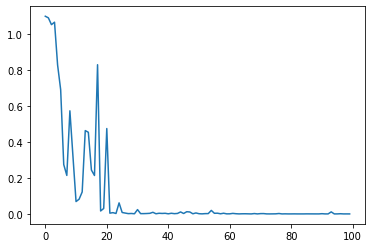

In [67]:
plt.plot(losses2)

### Preds

In [68]:
predss2 = []
batch_acc2 = []
for batch_idx, batch in enumerate(test_dl):

    input = batch[0].to(device)
    target = batch[1].to(device)

    optimizer.zero_grad()
    with torch.set_grad_enabled(False):
        out, hidden = model2(input, h0)
        _, preds = torch.max(out, 1)
        preds = preds.to("cpu").tolist()
        predss2.extend(preds)
        batch_acc2.append(accuracy_score(preds, target.tolist()))

sum(batch_acc2)/len(batch_acc2)

0.44999999999999996

### Validation on No Hashtags

In [69]:
predss2 = []
targetss2 = []
batch_acc2, f1, prec, recall = [], [], [], []
for batch_idx, batch in enumerate(noh_val_dl):

    input = batch[0].to(device)
    target = batch[1].to(device)

    optimizer.zero_grad()
    with torch.set_grad_enabled(False):
        out, hidden = model2(input, h0)
        _, preds = torch.max(out, 1)
        preds = preds.to("cpu").tolist()
        
        predss2.extend(preds)
        targetss2.extend(target.tolist())
        batch_acc2.append(accuracy_score(preds, target.tolist()))

print(sum(batch_acc)/len(batch_acc))
print(predss2)
print(targetss2)

0.4666666666666667
[1, 2, 2, 2, 2, 0, 1, 2, 2, 0, 2, 2, 1, 0, 0, 1, 2, 0, 2, 2, 2, 2, 1, 2, 0, 0, 0, 0, 2, 1, 2, 0, 2, 2, 2, 1, 1, 2, 1, 2, 2, 2, 2, 1, 0, 1, 1, 0, 1, 2, 1, 2, 0, 2, 2, 0, 1, 2, 1, 2, 1, 2, 0, 0, 1, 2, 1, 1, 0, 0, 1, 2, 2, 1, 1, 2, 0, 2, 2, 1, 2, 2, 2, 0, 2, 0, 2, 1, 1, 2, 1, 1, 0, 0, 2, 0, 1, 2, 2, 0, 0, 0, 1, 0, 2, 1, 1, 1, 0, 0, 2, 2, 2, 2, 2, 2, 1, 2, 0, 1, 2, 0, 0, 1, 1, 0, 0, 2, 2, 2, 2, 0, 0, 1, 0, 1, 0, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 2, 1, 0, 0, 1, 0, 1, 1, 2, 2, 1, 1, 0, 2, 0, 0, 0, 0, 2, 0, 1, 2, 1, 2, 1, 2, 0, 2, 0, 0, 0, 2, 0, 2, 2, 0, 0, 1, 2, 0, 0, 1, 1, 0, 2, 0, 1, 1, 2, 1, 0, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 0, 2, 2, 1, 2, 2, 0, 2, 0, 2, 2, 1, 2, 2, 1, 2, 1, 2, 2, 1, 2, 1, 0, 0, 1, 2, 2, 0, 1, 1, 1, 2, 2, 0, 2, 1, 0, 1, 1, 0, 1, 1, 1, 2, 1, 2, 1, 2, 2, 0, 0, 2, 2, 2, 1, 1, 0, 0, 2, 2, 1, 2, 2, 2, 2, 2, 0, 1, 1, 2, 0, 0, 2, 1, 2, 2, 2, 1, 2, 2, 1, 2, 0, 2, 1, 1, 2, 2, 2]
[0.0, 2.0, 1.0, 1.0, 2.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0,

In [70]:
f1_macro_no_hashtags2 = f1_score(targetss2, predss2, average = "macro")
print(f1_macro_no_hashtags2)
f1_weighted_no_hashtags2 = f1_score(targetss2, predss2, average = "weighted")
print(f1_weighted_no_hashtags2)
f1_micro_no_hashtags2 = f1_score(targetss2, predss2, average = "micro")
print(f1_micro_no_hashtags2)

0.37861845172683495
0.4069133791728628
0.39


In [71]:
prec_macro_no_hashtags2 = precision_score(targetss2, predss2, average = "macro")
print(prec_macro_no_hashtags2)
prec_weighted_no_hashtags2 = precision_score(targetss2, predss2, average = "weighted")
print(prec_weighted_no_hashtags2)
prec_micro_no_hashtags2 = precision_score(targetss2, predss2, average = "micro")
print(prec_micro_no_hashtags2)

0.41703912494987544
0.5121852544570598
0.39


In [72]:
rec_macro_no_hashtags2 = recall_score(targetss2, predss2, average = "macro")
print(rec_macro_no_hashtags2)
rec_weighted_no_hashtags2 = recall_score(targetss2, predss2, average = "weighted")
print(rec_weighted_no_hashtags2)
rec_micro_no_hashtags2 = recall_score(targetss2, predss2, average = "micro")
print(rec_micro_no_hashtags2)

0.427252226426633
0.39
0.39


### Validation on Hashtags

In [73]:
u_predss2 = []
u_targetss2 = []
u_batch_acc2, u_f1, u_prec, u_recall = [], [], [], []
for batch_idx, batch in enumerate(unp_val_dl):

    input = batch[0].to(device)
    target = batch[1].to(device)

    optimizer.zero_grad()
    with torch.set_grad_enabled(False):
        out, hidden = model2(input, h0)
        _, preds = torch.max(out, 1)
        preds = preds.to("cpu").tolist()
        
        u_predss2.extend(preds)
        u_targetss2.extend(target.tolist())
        u_batch_acc2.append(accuracy_score(preds, target.tolist()))

print(sum(u_batch_acc2)/len(u_batch_acc2))
print(u_predss2)
print(u_targetss2)

0.39666666666666667
[2, 1, 2, 1, 2, 1, 0, 0, 0, 0, 2, 2, 2, 1, 2, 1, 2, 1, 2, 2, 2, 0, 2, 0, 2, 1, 1, 0, 2, 1, 0, 0, 2, 2, 1, 0, 2, 1, 0, 0, 0, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 0, 2, 0, 2, 2, 2, 0, 2, 1, 1, 2, 0, 2, 1, 2, 2, 1, 2, 2, 2, 2, 1, 1, 1, 1, 0, 1, 0, 2, 2, 1, 0, 2, 0, 0, 0, 0, 2, 2, 2, 1, 0, 0, 0, 1, 0, 1, 1, 2, 2, 1, 2, 2, 0, 2, 2, 2, 1, 2, 2, 2, 0, 1, 1, 1, 1, 2, 2, 2, 2, 0, 0, 1, 1, 1, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 1, 0, 1, 2, 1, 2, 2, 2, 2, 1, 2, 2, 1, 0, 1, 2, 0, 1, 2, 0, 1, 2, 2, 2, 1, 2, 0, 1, 2, 1, 1, 2, 0, 2, 0, 1, 2, 2, 2, 2, 2, 0, 1, 1, 2, 2, 2, 2, 1, 0, 2, 2, 0, 2, 2, 2, 0, 0, 2, 2, 2, 2, 0, 1, 0, 1, 0, 0, 0, 0, 2, 0, 1, 0, 0, 2, 2, 0, 0, 1, 1, 2, 2, 2, 0, 2, 0, 2, 0, 2, 0, 0, 0, 2, 1, 2, 2, 2, 1, 2, 2, 2, 0, 1, 1, 1, 2, 2, 1, 1, 0, 1, 1, 0, 2, 2, 1, 2, 1, 0, 0, 2, 2, 0, 1, 0, 1, 0, 1, 1, 2, 1, 1, 1, 1, 2, 0, 2, 0, 2, 1, 0, 2, 0, 2, 2, 2, 2, 1, 2, 2, 2, 1, 2, 1, 1, 0, 2, 1, 0, 1, 0, 0, 0]
[1.0, 0.0, 0.0, 2.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0

In [74]:
f1_macro_unpacked2 = f1_score(u_targetss2, u_predss2, average = "macro")
print(f1_macro_unpacked2)
f1_weighted_unpacked2 = f1_score(u_targetss2, u_predss2, average = "weighted")
print(f1_weighted_unpacked2)
f1_micro_unpacked2 = f1_score(u_targetss2, u_predss2, average = "micro")
print(f1_micro_unpacked2)

0.383827331338032
0.4174804785212535
0.39666666666666667


In [75]:
prec_macro_unpacked2 = precision_score(u_targetss2, u_predss2, average = "macro")
print(prec_macro_unpacked2)
prec_weighted_unpacked2 = precision_score(u_targetss2, u_predss2, average = "weighted")
print(prec_weighted_unpacked2)
prec_micro_unpacked2 = precision_score(u_targetss2, u_predss2, average = "micro")
print(prec_micro_unpacked2)

0.4281856781642097
0.5299277706216308
0.39666666666666667


In [76]:
rec_macro_unpacked2 = recall_score(u_targetss2, u_predss2, average = "macro")
print(rec_macro_unpacked2)
rec_weighted_unpacked2 = recall_score(u_targetss2, u_predss2, average = "weighted")
print(rec_weighted_unpacked2)
rec_micro_unpacked2 = recall_score(u_targetss2, u_predss2, average = "micro")
print(rec_micro_unpacked2)

0.4255430242272347
0.39666666666666667
0.39666666666666667
